# Isodensity lines in R and $\rho$

In [1]:
%matplotlib notebook

from IPython.core.display import display, HTML
from ipfnpytools.getsig import getsig
import ipfnpytools.aug_read as aug_read
from ipfnpytools.closest import closest
import matplotlib.pyplot as plt
from __future__ import print_function
from ipfnpytools.plot import plots
from warnings import warn
import numpy as np
from ipfnpytools.save_figure import save_figure
from ipfnpytools import rps_dump

## Parameters

Change at your own risk. Not guaranteed it will not explode

In [2]:
# Shot number
shot = 37750

# Choose profile source between 'afs' and 'dump'
source = 'afs'

# If chosen 'dump', state the relative path
path = None

# Magnetic equillibrium
equillibrium = "EQH"

# Adjust Isodensity parameters
n_iso = 10           # Number of lines
start_density = 3e18 # First isodensity
stop_density = 3e19  # Last isodensity

In [3]:
# Fetching data ---------------------------------------------------

if source == 'afs':

    data = aug_read.many_signals(
        diagnostics=(["RPS"] * 2),
        names=['neb_LFS', 'neb_HFS'],
        shots=shot)

    # Time array is equal for LFS and HFS
    time = data.times[0]

    # Low-field side
    lfs_signal = data.signals[0]
    lfs_area = data.areas[0]

    # High-field side
    hfs_signal = data.signals[1]
    hfs_area = data.areas[1]
    
elif source == 'dump':
    
    # Instantiate the ShotFile class with the path to the dump file
    shotfile = rps_dump.ShotFile(path)

    ne_lfs = shotfile("neb_LFS")
    ne_hfs = shotfile("neb_HFS")

    # Time array is equal for LFS and HFS
    time = ne_lfs.time

    # Low-field side
    lfs_signal = ne_lfs.data
    lfs_area = ne_lfs.area.data

    # High-field side
    hfs_signal = ne_hfs.data
    hfs_area = ne_hfs.area.data
    
else:
    raise(TypeError)
    
print("time:", time.shape)
print("lfs_signal:", lfs_signal.shape)
print("lfs_area:", lfs_area.shape)
print("hfs_signal:", hfs_signal.shape)
print("hfs_area:", hfs_area.shape)

/afs/ipp/aug/ads-diags/common/python/lib/dd.py:118: RuntimeWarning: Warning by DDcsgrp (8.1): No PARAM_SET found
  warnings.warn(err_txt, RuntimeWarning)


time: (37323,)
lfs_signal: (37323, 151)
lfs_area: (37323, 151)
hfs_signal: (37323, 151)
hfs_area: (37323, 151)


In [4]:
# Preprocessing --------------------------------------------------

#Isodensities. Transpose `area` so density is the first index
lfs_isodensity = lfs_area.T
hfs_isodensity = hfs_area.T
density = lfs_signal[0,:]

print("lfs_isodensity", lfs_isodensity.shape)
print("density", density.shape)
print("time", time.shape)

last_index = closest(density, stop_density)
first_index = closest(density, start_density)

if (last_index - first_index + 1) < n_iso:
    warn("Impossible drawing " + str(n_iso) + " isodensities, drawing only " + str(last_index - first_index + 1))

# ------------------------ CHOOSE ONE -------------------------------    
    
# Guarantees uniform spacing but not inclusion of last isodensity
# drawing_indexes = range(first_index, last_index + 1, (last_index - first_index + 1)/n_iso)

# Guarantees inclusion of last isodensity but not uniform spacing
drawing_indexes = np.rint(np.linspace(first_index, last_index, n_iso)).astype(np.int)

print("Drawing_indexes:", drawing_indexes)

lfs_isodensity (151, 37323)
density (151,)
time (37323,)
Drawing_indexes: [31 38 46 53 61 68 76 83 91 98]


<IPython.core.display.Javascript object>


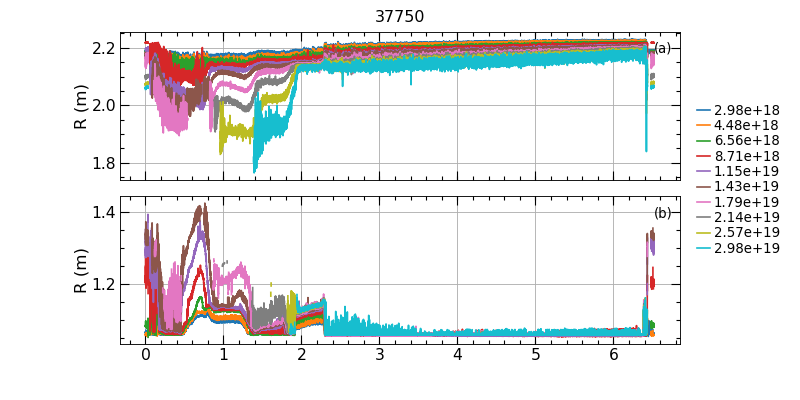

In [6]:
fig, axes = plots(x=time, y=[lfs_isodensity[i] for i in drawing_indexes] + [hfs_isodensity[i] for i in drawing_indexes], 
                  boxes=[0]*n_iso + [1]*n_iso, 
                  labels=["%.2e" % density[i] for i in drawing_indexes] + [None]*len(drawing_indexes),
                  legend_kw={'loc':'center left', 'bbox_to_anchor':[1.02,-1,0.3,2]},
                  y_mins=[None]*n_iso + [None]*n_iso,
                  y_maxs=[None]*n_iso + [None]*n_iso,
                  sharex=True,
                  y_labels="R (m)",
                  title=str(shot))
fig.set_size_inches(10, 5)
# axes[0].text(x=2.6, y=2, s="LFS", fontsize='x-large')
# axes[1].text(x=2.6, y=1.3, s="HFS", fontsize='x-large')
# plt.show()

In [26]:
save_figure(fig, "%d_isodensity" % (shot))

Figure saved to /afs/ipp-garching.mpg.de/home/d/danielhfc/phd-logbooks/logbooks/37765/37765_isodensity.png


## Adding separatrix information

In [40]:
import dd #To read 
import kk_abock
import numpy as np
from ipfnpytools.trz_to_rhop import trz_to_rhop
from ipfnpytools.trhoptheta_to_rz import trhoptheta_to_rz
from ipfnpytools.getsig import getsig
import matplotlib.patheffects as pe

In [6]:
# Set the antenna Z
zl = 0.14
zh = 0.07

# Get lower x point
rxpu = getsig(shot, 'GQH', 'Rxpu')
zxpu = getsig(shot, 'GQH', 'Zxpu')

# Get upper x point
rxpo = getsig(shot, 'GQH', 'Rxpo')
zxpo = getsig(shot, 'GQH', 'Zxpo')

rho_x_u = trz_to_rhop(rxpu.time, rxpu.data, zxpu.data, 
                      shot=shot, eq=equillibrium)
rho_x_u = np.diag(rho_x_u)

rho_x_o = trz_to_rhop(rxpo.time, rxpo.data, zxpo.data, 
                      shot=shot, eq=equillibrium)
rho_x_o = np.diag(rho_x_o)

print(rho_x_u)
print(rho_x_o)


# # Walls
# inner_wall = 1.045
# outer_wall = 2.22

# inner_wall_rho = trz_to_rhop(3, inner_wall, zh, shot, eq=equillibrium)
# outer_wall_rho = trz_to_rhop(3, outer_wall, zl, shot, eq=equillibrium)
# rhol = trz_to_rhop(time, lfs_area, np.ones_like(lfs_area)*zl, shot, eq=equillibrium)
# rhoh = trz_to_rhop(time, hfs_area, np.ones_like(hfs_area)*zh, shot, eq=equillibrium)

/afs/ipp/aug/ads-diags/common/python/lib/dd.py:118: RuntimeWarning: Warning by DDcsgnl (8.1): no calibration of data
  warnings.warn(err_txt, RuntimeWarning)


trz_to_rhop:8562/8562
trz_to_rhop:8562/8562
[2.6524332  2.2777662  2.2584305  ... 0.9999883  0.9999871  0.99999636]
[1.3536406 1.3555607 1.3527447 ... 1.1252593 1.1380731 1.1729356]


In [31]:
# Discover R of secondary separatrix

r_second_hfs = []
for t, rho in zip(rxpo.time, rho_x_o):
    r_second_hfs.append(trhoptheta_to_rz(t, rho, np.pi, shot=shot, eq=equillibrium, verbose=False)[0])
r_second_hfs = np.array(r_second_hfs)
    
r_second_lfs = []
for t, rho in zip(rxpo.time, rho_x_o):
    r_second_lfs.append(trhoptheta_to_rz(t, rho, 0, shot=shot, eq=equillibrium, verbose=False)[0])  
r_second_lfs = np.array(r_second_lfs)

# Separatrix positions
rin = getsig(shot, 'GQH', 'Rin')
raus = getsig(shot, 'GQH', 'Raus')

**The next cell draws the separatrix and secondary separatrix on the previous plot**

To refresh the plot and erase the separatrix information simply re-execute the plotting cell 

In [49]:
axes[0].plot(raus.time, raus.data, color='black', linestyle='--', label='sep.', alpha=0.6, path_effects=[pe.Stroke(linewidth=5, alpha=0.6, foreground='w'), pe.Normal()])
axes[1].plot(rin.time, rin.data, color='black', linestyle='--', label='sep.', alpha=0.6, path_effects=[pe.Stroke(linewidth=5, alpha=0.6, foreground='w'), pe.Normal()])

axes[0].plot(rxpo.time, r_second_lfs, color='red', linestyle='--', label='2$^{nd}$ sep.', alpha=0.6, path_effects=[pe.Stroke(linewidth=5, alpha=0.6, foreground='w'), pe.Normal()])
axes[1].plot(rxpo.time, r_second_hfs, color='red', linestyle='--', label='2$^{nd}$ sep.', alpha=0.6, path_effects=[pe.Stroke(linewidth=5, alpha=0.6, foreground='w'), pe.Normal()])

axes[0].legend(loc='center left', bbox_to_anchor=[1.02,-1,0.3,2]);